# Imports

In [3]:
# from google.colab.patches import cv2_imshow
import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as poly

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import gzip

import os
import glob
import time
import random
import gc
import json
import copy
import pyprind
import tqdm
import itertools
import pickle as pkl
from dataclasses import dataclass, field
from typing import Union, List, Dict, Any, Optional, cast

import torch
import torchvision


from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

# Data

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                #  (0.1307,), (0.3081,)
                                (0.5,), (0.5,)
                                 )
                             ])),
  batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                #  (0.1307,), (0.3081,))
                                (0.5,), (0.5,))
                             ])),
  batch_size=1000, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
# print(example_data.shape)

# Arguments

In [12]:
@dataclass
class TrainingArgs():

    num_workers: int = os.cpu_count()
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    size: int = int(1e4)
    range: int = 10
    input_size: int = 784
    channels: tuple = (16, 16, 16, 16)
    k: int = 1


args = TrainingArgs()

---

# Model

## DNN

In [13]:
class DNN(nn.Module):
    def __init__(self, args):
        super(DNN, self).__init__()
        self.args = args

        self.fc0 = nn.Linear(in_features=self.args.input_size, out_features=self.args.channels[0], bias=True)
        self.fc1 = nn.Linear(in_features=self.args.channels[0], out_features=self.args.channels[1], bias=True)
        self.fc2 = nn.Linear(in_features=self.args.channels[1], out_features=self.args.channels[2], bias=True)
        if len(args.channels) == 4:
            self.fc3 = nn.Linear(in_features=self.args.channels[2], out_features=self.args.channels[3], bias=True)
            self.fc4 = nn.Linear(in_features=self.args.channels[3], out_features=10, bias=True)
        elif len(args.channels) == 3:
            self.fc4 = nn.Linear(in_features=self.args.channels[2], out_features=10, bias=True)        

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):

        out = self.fc0(x)
        act = torch.where(out>0, torch.ones(1,).to(self.args.device), torch.zeros(1,).to(self.args.device))
        out = self.act(out)
        subnetwork = act

        out = self.fc1(out)
        act = torch.where(out>0, torch.ones(1,).to(self.args.device), torch.zeros(1,).to(self.args.device))
        out = self.act(out)
        subnetwork = torch.cat((subnetwork, act), dim=1)

        out = self.fc2(out)
        act = torch.where(out>0, torch.ones(1,).to(self.args.device), torch.zeros(1,).to(self.args.device))
        out = self.act(out)
        subnetwork = torch.cat((subnetwork, act), dim=1)
        
        if len(args.channels) == 4:
            out = self.fc3(out)
            act = torch.where(out>0, torch.ones(1,).to(self.args.device), torch.zeros(1,).to(self.args.device))
            out = self.act(out)
            subnetwork = torch.cat((subnetwork, act), dim=1)

        out = self.fc4(out)
    
        return out, subnetwork

## Testing

In [14]:
dnn = DNN(args).to(args.device)
x = torch.rand((1, 784)).to(args.device)

In [15]:
out, subnetwork = dnn(x)
# out.shape
print(subnetwork)

tensor([[0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
         1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
         1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
         1., 1., 1., 1., 0., 0., 0., 1., 0., 1.]], device='cuda:0')


# Trainer

In [18]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=128
lr = 1e-3
epochs = 20
model = DNN(args).to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

def accuracy(y_pred, y):
    _, predicted = torch.max(y_pred.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct/total

def train(model, dataset, optimizer, loss, device):
    
    train_loss = []
    epoch_metrics = {'accuracy': 0, 'subnetwork': {}}
    model.train()
    for idx, (images, labels) in enumerate(dataset):
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(images.shape[0], -1)
        output, subnetwork = model(images)
        train_loss = loss(output,labels)
        # train_loss_batch.append(train_loss)
        acc = accuracy(output, labels)
        # accu_train_batch.append(acc)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        epoch_metrics['accuracy'] += acc/len(dataset)
        for index in range(images.size(0)):
            id = ''.join([str(int(item)) for item in subnetwork[index, :].detach().cpu().tolist()])
            if id in epoch_metrics['subnetwork'].keys():
                epoch_metrics['subnetwork'][id].extend([images[index, 0:2].detach().cpu().numpy()])
            else:
                epoch_metrics['subnetwork'][id] = [images[index, 0:2].detach().cpu().numpy()]

    return epoch_metrics
    

def test(model, dataset, device):
    
    test_loss = []
    epoch_metrics = {'accuracy': 0, 'subnetwork': {}}
    model.eval()
    for idx, (images, labels) in enumerate(dataset):
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(images.shape[0], -1)
            output, subnetwork = model(images)
            # test_loss = criterion(output,labels)
            # test_loss_batch.append(test_loss)
            acct = accuracy(output, labels)
            epoch_metrics['accuracy'] += acct/len(dataset)
            for index in range(images.size(0)):
                id = ''.join([str(int(item)) for item in subnetwork[index, :].detach().cpu().tolist()])
                if id in epoch_metrics['subnetwork'].keys():
                    epoch_metrics['subnetwork'][id].extend([images[index, 0:2].detach().cpu().numpy()])
                else:
                    epoch_metrics['subnetwork'][id] = [images[index, 0:2].detach().cpu().numpy()]

    return epoch_metrics
            
    


# Training

Training Done for Model Type:(16, 16, 16, 16)
Training Done for Model Type:(32, 32, 32, 32)
Training Done for Model Type:(64, 64, 64, 64)
Training Done for Model Type:(20, 20, 20)
Training Done for Model Type:(40, 40, 40)
Training Done for Model Type:(60, 60, 60)
Training Done for Model Type:(80, 80, 80)


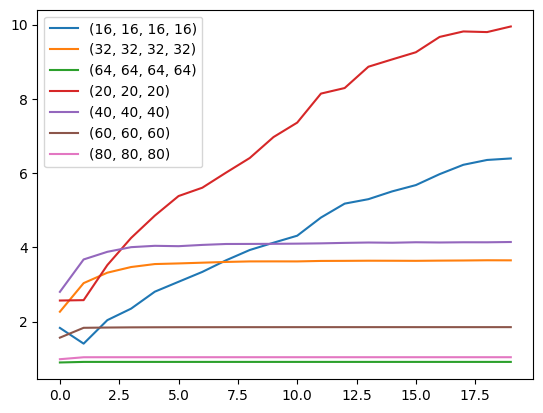

In [21]:
train_metrics = {'accuracy': [], 'subnetwork': {}}
test_metrics = {'accuracy': [], 'subnetwork': {}}
subnetworks_epochs = {}
models = [(16, 16, 16, 16), (32, 32, 32, 32), (64, 64, 64, 64), (20, 20, 20), (40, 40, 40), (60, 60, 60), (80, 80, 80)]
neurons = [16*4, 32*4, 64*4, 20*3, 40*3, 60*3, 80*3]
for index in range(len(models)):
    model_type = models[index]
    args.channels = model_type
    model = DNN(args).to(args.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        epoch_train_metrics = train(model, train_loader, optimizer, criterion, device)
        train_metrics['accuracy'].append(epoch_train_metrics['accuracy'])
        # get_plot(epoch_train_metrics, "DRN")
        if model_type in subnetworks_epochs.keys():
            subnetworks_epochs[model_type].append(len(epoch_train_metrics['subnetwork'].keys())/(neurons[index]*neurons[index]))
        else:
            subnetworks_epochs[model_type] = [len(epoch_train_metrics['subnetwork'].keys())/(neurons[index]*neurons[index])]
    print(f"Training Done for Model Type:{model_type}")
    
for model_type in subnetworks_epochs.keys():
    plt.plot(subnetworks_epochs[model_type], label=str(model_type))
plt.legend()
plt.savefig("Expt3_AR.png")

---

# Effect of Learning Rate

Training Done for Learning Rate:0.01
Training Done for Learning Rate:0.001
Training Done for Learning Rate:0.0001
Training Done for Learning Rate:1e-05


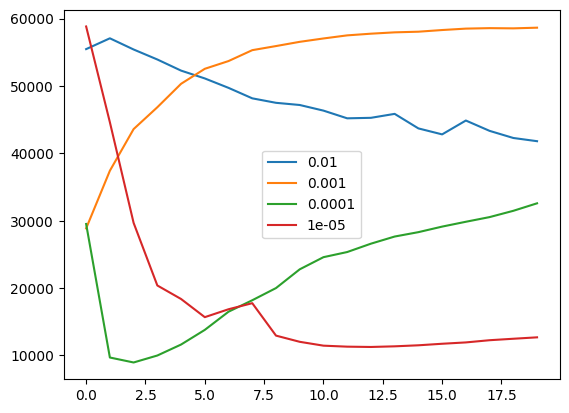

In [22]:
# print(f"Expt: {lr}")
# epoch_loss = 0
train_metrics = {'accuracy': [], 'subnetwork': {}}
test_metrics = {'accuracy': [], 'subnetwork': {}}
subnetworks_epochs = {}
models = [(32, 32, 32)]
lr_s = [1e-2, 1e-3, 1e-4, 1e-5]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=128
epochs = 20
criterion = nn.CrossEntropyLoss()
for index in range(len(lr_s)):
    model_type = models[0]
    lr = lr_s[index]
    args.channels = model_type
    model = DNN(args).to(args.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        epoch_train_metrics = train(model, train_loader, optimizer, criterion, device)
        train_metrics['accuracy'].append(epoch_train_metrics['accuracy'])
        # get_plot(epoch_train_metrics, "DRN")
        if lr in subnetworks_epochs.keys():
            subnetworks_epochs[lr].append(len(epoch_train_metrics['subnetwork'].keys()))
        else:
            subnetworks_epochs[lr] = [len(epoch_train_metrics['subnetwork'].keys())]
    print(f"Training Done for Learning Rate:{lr}")
    
for lr in subnetworks_epochs.keys():
    plt.plot(subnetworks_epochs[lr], label=str(lr))
plt.legend()
plt.savefig("Expt6_AR.png")
